## Load HIV dataset

In [138]:
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [139]:
df = pd.read_csv("HIV.csv")
df.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


In [140]:
string = df.loc[0,'smiles']
print(df.loc[0,'smiles'])
print(string[3])

CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)=[O+]2
1


In [141]:
df.value_counts("activity")

activity
CI    39684
CM     1039
CA      404
Name: count, dtype: int64

In [142]:
df.value_counts("HIV_active")

HIV_active
0    39684
1     1443
Name: count, dtype: int64

## Sampling 

In [143]:
# Separate the dataframe into three categories
df_CI = df[df['activity'] == 'CI']
df_CM = df[df['activity'] == 'CM']
df_CA = df[df['activity'] == 'CA']

# Sampling from each category
sample_CI = df_CI.sample(n=1000, random_state=42) 
sample_CM = df_CM.sample(n=700, random_state=42)
sample_CA = df_CA.sample(n=300, random_state=42)

# Concatenate the samples back into one DataFrame
sampled_sf = pd.concat([sample_CI, sample_CM, sample_CA])

# Shuffle the combined DataFrame
sampled_sf = sampled_sf.sample(frac=1, random_state=42).reset_index(drop=True)
sampled_sf

,smiles,activity,HIV_active
0,CNc1ccc(C)cc1S(=O)(=O)c1ccccc1[N+](=O)[O-],CA,1
1,Cc1cccc(C)c1NC(=O)C(Cc1nc2ccc([N+](=O)[O-])cc2...,CI,0
2,CC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(S(=O)(=O)c3ccc(-n...,CM,1
3,Oc1on[n+]2c1Cc1ccccc1C2,CI,0
4,CC(C)CCCC(C)C1CCC2C3CCC4CC(NC(=O)CC=C(c5cc(Cl)...,CM,1
...,...,...,...
1995,CC(C)CC(CC(O)C(Cc1ccccc1)NC(=O)OC1CCOC1)S(=O)(...,CM,1
1996,CCCCCCCC1(N=[N+]=[N-])C(=O)c2ccccc2N(C)C1=O,CM,1
1997,CC(CC(=O)Nc1ccc([N+](=O)[O-])cc1)=NNc1ccc([N+]...,CI,0
1998,NCCC=C(c1cc(Cl)c(O)c(C(=O)O)c1)c1cc(Cl)c(O)c(C...,CM,1


CNc1ccc(C)cc1S(=O)(=O)c1ccccc1[N+](=O)[O-]


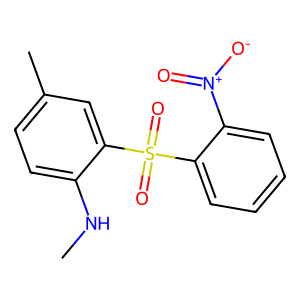

In [144]:
from rdkit import Chem
from rdkit.Chem import Draw
import networkx as nx

smiles = sampled_sf['smiles'].iloc[0]
print(smiles)

# Visualizing the first molecule's structure as an example
mol = Chem.MolFromSmiles(smiles)
Draw.MolToImage(mol)

## Transform SMILES into Graph representation

In [145]:
import torch
from torch_geometric.data import Data

# Atom and bond preprocessing functions
def atom_features(atom):
    return [
        atom.GetAtomicNum(),             # Atomic number
        atom.GetFormalCharge(),          # Formal charge
        atom.GetDegree(),                # Degree of the atom
        atom.GetHybridization().real,    # Hybridization
        atom.GetIsAromatic(),            # Aromaticity
        atom.GetImplicitValence(),       # Implicit valence
        atom.GetMass(),                  # Atomic mass 
        atom.GetTotalDegree(),           # Total number of bonds
        atom.GetTotalValence(),          # Total valence electrons
    ]

def bond_features(bond):
    bt = bond.GetBondType()
    return [
        bt == Chem.rdchem.BondType.SINGLE,
        bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE,
        bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),  # Conjugation
        bond.IsInRing(),         # Whether the bond is in a ring
    ]

# Conversion from SMILES to graph suitable for GNN
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
        
    mol = Chem.AddHs(mol)# Add explicit hydrogens
    
    # Create nodes
    node_feats = [atom_features(atom) for atom in mol.GetAtoms()]
    node_feats = torch.tensor(node_feats, dtype=torch.float)
    
    # Create edges
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
        edge_attr += [bond_features(bond), bond_features(bond)]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    return Data(x=node_feats, edge_index=edge_index, edge_attr=edge_attr)

# Apply the function to your dataframe
sampled_sf['graph'] = sampled_sf['smiles'].apply(smiles_to_graph)
print(sampled_sf['graph'].iloc[0].x)
sampled_sf

tensor([[ 6.0000,  0.0000,  4.0000,  4.0000,  0.0000,  0.0000, 12.0110,  4.0000,
          4.0000],
        [ 7.0000,  0.0000,  3.0000,  3.0000,  0.0000,  0.0000, 14.0070,  3.0000,
          3.0000],
        [ 6.0000,  0.0000,  3.0000,  3.0000,  1.0000,  0.0000, 12.0110,  3.0000,
          4.0000],
        [ 6.0000,  0.0000,  3.0000,  3.0000,  1.0000,  0.0000, 12.0110,  3.0000,
          4.0000],
        [ 6.0000,  0.0000,  3.0000,  3.0000,  1.0000,  0.0000, 12.0110,  3.0000,
          4.0000],
        [ 6.0000,  0.0000,  3.0000,  3.0000,  1.0000,  0.0000, 12.0110,  3.0000,
          4.0000],
        [ 6.0000,  0.0000,  4.0000,  4.0000,  0.0000,  0.0000, 12.0110,  4.0000,
          4.0000],
        [ 6.0000,  0.0000,  3.0000,  3.0000,  1.0000,  0.0000, 12.0110,  3.0000,
          4.0000],
        [ 6.0000,  0.0000,  3.0000,  3.0000,  1.0000,  0.0000, 12.0110,  3.0000,
          4.0000],
        [16.0000,  0.0000,  4.0000,  4.0000,  0.0000,  0.0000, 32.0670,  4.0000,
          6.0000],


,smiles,activity,HIV_active,graph
0,CNc1ccc(C)cc1S(=O)(=O)c1ccccc1[N+](=O)[O-],CA,1,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
1,Cc1cccc(C)c1NC(=O)C(Cc1nc2ccc([N+](=O)[O-])cc2...,CI,0,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
2,CC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(S(=O)(=O)c3ccc(-n...,CM,1,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
3,Oc1on[n+]2c1Cc1ccccc1C2,CI,0,"[(x, [tensor([ 8.0000, 0.0000, 2.0000, 3.00..."
4,CC(C)CCCC(C)C1CCC2C3CCC4CC(NC(=O)CC=C(c5cc(Cl)...,CM,1,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
...,...,...,...,...
1995,CC(C)CC(CC(O)C(Cc1ccccc1)NC(=O)OC1CCOC1)S(=O)(...,CM,1,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
1996,CCCCCCCC1(N=[N+]=[N-])C(=O)c2ccccc2N(C)C1=O,CM,1,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
1997,CC(CC(=O)Nc1ccc([N+](=O)[O-])cc1)=NNc1ccc([N+]...,CI,0,"[(x, [tensor([ 6.0000, 0.0000, 4.0000, 4.00..."
1998,NCCC=C(c1cc(Cl)c(O)c(C(=O)O)c1)c1cc(Cl)c(O)c(C...,CM,1,"[(x, [tensor([ 7.0000, 0.0000, 3.0000, 4.00..."


## GNN

In [22]:
for i, data in enumerate(sampled_sf['graph']):
    data.y = torch.tensor([sampled_sf['HIV_active'][i]], dtype=torch.long)
print(sampled_sf['graph'][0])

Data(x=[21, 7], edge_index=[2, 44], edge_attr=[44, 6], y=[1])


In [23]:
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader 

sampled_sf = sampled_sf.reset_index(drop=True)
# Split data into training and testing sets
train_dataset, val_dataset = train_test_split(sampled_sf['graph'].tolist(), test_size=0.2, random_state=42)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [24]:
import torch.optim as optim
from tqdm import tqdm
from torch.nn import Linear, ReLU, Sequential
from torch_geometric.utils import scatter
from torch_geometric.loader import DataLoader as GraphDataLoader

class Layer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.layers = Sequential(
            Linear(in_dim, out_dim),
            ReLU()
        )
    
    def forward(self, x):
        return self.layers(x)

class MessagePassingLayer(nn.Module):
    def __init__(self, node_hidden_dim, edge_hidden_dim):
        super().__init__()
        self.edge_net = Layer(2 * node_hidden_dim + edge_hidden_dim, edge_hidden_dim)
        self.node_net = Layer(node_hidden_dim + edge_hidden_dim, node_hidden_dim)
    
    def forward(self, node_features, edge_features, edge_index):
        src, dest = edge_index[0], edge_index[1]
        edge_features_combined = torch.cat([
            node_features[src],
            node_features[dest],
            edge_features
        ], dim=1)
        updated_edge_features = self.edge_net(edge_features_combined)
        aggr_edge_features = scatter(updated_edge_features, src, dim_size=node_features.size(0))
        node_features_combined = torch.cat([node_features, aggr_edge_features], dim=1)
        updated_node_features = self.node_net(node_features_combined)
        return updated_node_features, updated_edge_features

class GraphNet(nn.Module):
    def __init__(self, node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim, num_classes):
        super().__init__()
        self.node_embed = Layer(node_input_dim, node_hidden_dim)
        self.edge_embed = Layer(edge_input_dim, edge_hidden_dim)
        self.message_passing = MessagePassingLayer(node_hidden_dim, edge_hidden_dim)
        self.readout = Linear(node_hidden_dim, num_classes)
    
    def forward(self, data):
        node_hidden = self.node_embed(data.x)
        edge_hidden = self.edge_embed(data.edge_attr)
        node_hidden, edge_hidden = self.message_passing(node_hidden, edge_hidden, data.edge_index)
        graph_embeddings = scatter(node_hidden, data.batch, dim=0)
        out = self.readout(graph_embeddings)
        return out

In [25]:
from sklearn.metrics import confusion_matrix

class GNNTrainer:
    def __init__(self, model, batch_size=32, learning_rate=1e-3, epoch=10, l2=1e-5):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
        
    def train(self, train_loader, draw_curve=True):  
        self.model.train()
        loss_func = nn.CrossEntropyLoss()
        batch_loss_list = []
        for i in range(self.epoch):
            print(f"Epoch: {i}")
            for batch_data in tqdm(train_loader, leave=False):
                self.optimizer.zero_grad()
                batch_pred = self.model(batch_data)  # Assume model handles the batch_data correctly
                batch_loss = loss_func(batch_pred, batch_data.y)
                batch_loss.backward()
                self.optimizer.step()

                batch_loss_list.append(batch_loss.item())
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(np.arange(len(batch_loss_list)), batch_loss_list)
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
            plt.show()
        
        return batch_loss_list
    
    def evaluate(self, val_loader, draw_curve=True):
        self.model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for batch_data in tqdm(val_loader, leave=False):
                batch_pred = self.model(batch_data)
                y_pred.extend(batch_pred.argmax(dim=1).cpu().numpy())
                y_true.extend(batch_data.y.cpu().numpy())
        
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        accuracy = np.mean(y_true == y_pred)
        
        if draw_curve:
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
            plt.title("Confusion Matrix")
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
            
        return accuracy

In [26]:
num_classes = 2  # HIV_active: 0 1
node_input_dim = sampled_sf['graph'][0].x.shape[1] 
edge_input_dim = sampled_sf['graph'][0].edge_attr.shape[1]  
node_hidden_dim = 64
edge_hidden_dim = 64
model = GraphNet(node_input_dim, edge_input_dim, node_hidden_dim, edge_hidden_dim, num_classes)

GraphNet - Number of parameters: 21698
Epoch: 0


Epoch: 1


Epoch: 2


Epoch: 3


Epoch: 4


Epoch: 5


Epoch: 6


Epoch: 7


Epoch: 8


Epoch: 9


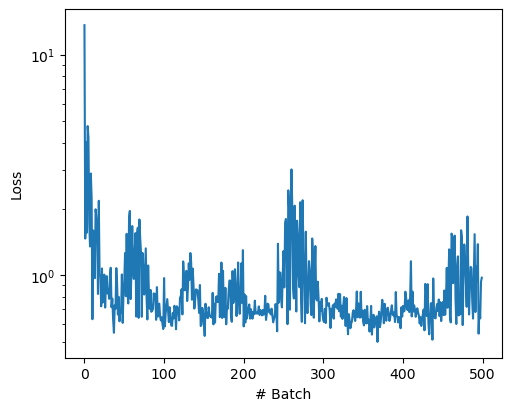

[13.654386520385742,
 1.4674625396728516,
 4.026464939117432,
 1.561139464378357,
 4.755828857421875,
 4.237755298614502,
 1.723826289176941,
 1.3510704040527344,
 2.897331953048706,
 2.248875141143799,
 0.6316266059875488,
 1.5981152057647705,
 1.0771827697753906,
 0.9701247215270996,
 1.9930250644683838,
 1.8266164064407349,
 1.5417145490646362,
 0.8223135471343994,
 2.1776223182678223,
 1.0068778991699219,
 0.9880767464637756,
 0.722998321056366,
 1.0738427639007568,
 0.7521507740020752,
 0.9636772871017456,
 1.0065325498580933,
 0.7135477662086487,
 0.9350734353065491,
 0.9912529587745667,
 0.8272554278373718,
 0.8614911437034607,
 0.7816893458366394,
 1.0001729726791382,
 1.081444263458252,
 0.715999186038971,
 0.7829962372779846,
 0.6294398307800293,
 0.5481583476066589,
 0.729668378829956,
 0.703432559967041,
 1.0774540901184082,
 0.9192031025886536,
 0.6629146933555603,
 0.7980760931968689,
 0.6179654598236084,
 0.6954563856124878,
 0.676263689994812,
 1.0087480545043945,
 0.60

In [27]:
trainer = GNNTrainer(model)
trainer.train(train_loader)

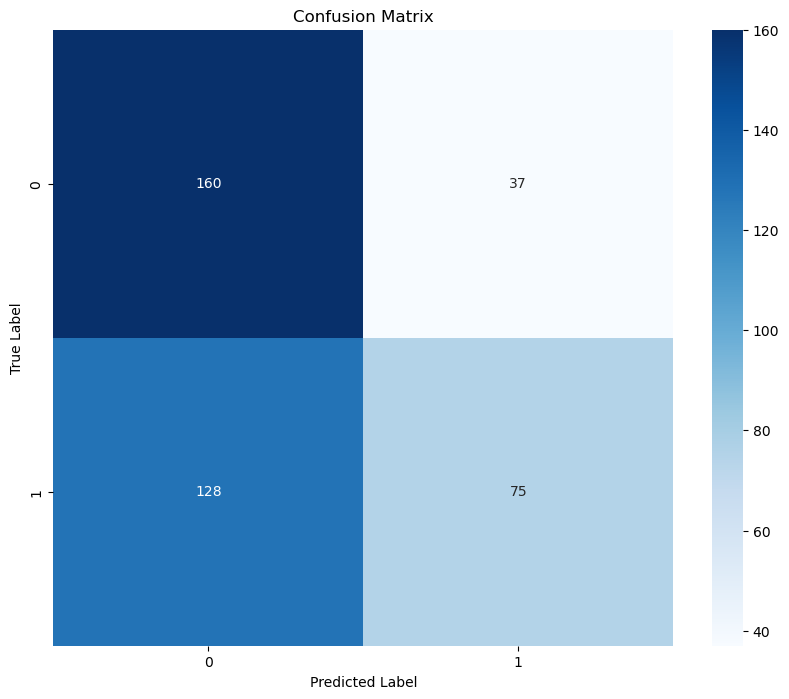

0.5875

In [28]:
# evaulate
trainer.evaluate(val_loader)